# Auto-encoders


In this part of the project, we implement a self-made CNN to build a non-linear and convolutional autoencoder. In more detail, we build and test various architectures under different circumnstances each time (training epochs, cost functions, batch size), check the reconstruction error and finally present the reconstruction of a random initial image per autoencoder. 

The different autoencoder architectures tested, contain either different number of coding variables, different number of convolutional layers and downsamples, or optimizers, loss and activation functions.  Also, either very large models were constructed or light-weight architectures that are presented subsequently, recording their performance. Some different scenarios are used in order to test the baseline models which are listed below. 

#### Download the data

In [0]:
!wget -cq http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xvf VOCtrainval_11-May-2009.tar

VOCdevkit/
VOCdevkit/VOC2009/
VOCdevkit/VOC2009/Annotations/
VOCdevkit/VOC2009/Annotations/2007_000027.xml
VOCdevkit/VOC2009/Annotations/2007_000032.xml
VOCdevkit/VOC2009/Annotations/2007_000033.xml
VOCdevkit/VOC2009/Annotations/2007_000039.xml
VOCdevkit/VOC2009/Annotations/2007_000042.xml
VOCdevkit/VOC2009/Annotations/2007_000061.xml
VOCdevkit/VOC2009/Annotations/2007_000063.xml
VOCdevkit/VOC2009/Annotations/2007_000068.xml
VOCdevkit/VOC2009/Annotations/2007_000121.xml
VOCdevkit/VOC2009/Annotations/2007_000123.xml
VOCdevkit/VOC2009/Annotations/2007_000129.xml
VOCdevkit/VOC2009/Annotations/2007_000170.xml
VOCdevkit/VOC2009/Annotations/2007_000175.xml
VOCdevkit/VOC2009/Annotations/2007_000187.xml
VOCdevkit/VOC2009/Annotations/2007_000241.xml
VOCdevkit/VOC2009/Annotations/2007_000243.xml
VOCdevkit/VOC2009/Annotations/2007_000250.xml
VOCdevkit/VOC2009/Annotations/2007_000256.xml
VOCdevkit/VOC2009/Annotations/2007_000272.xml
VOCdevkit/VOC2009/Annotations/2007_000323.xml
VOCdevkit/VOC2009/A

#### Import the appropriate packages

In [0]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import cv2
from sklearn.metrics import mean_squared_error

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [1]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

#### Build the data in the format needed

In [0]:
# set parameters before running this script
filter = ['aeroplane', 'car', 'chair', 'dog', 'bird']       # select class, this default should yield 1489 training and 1470 validation images
voc_root_folder = "./VOCdevkit/"  
#image_size = 214    
#image_size = 212
image_size = 208 # image size that we use for the network (input images will be resampled to this size)

In [0]:
# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)

In [0]:
# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/") #path in order to reach Main file
classes_files = os.listdir(classes_folder)

In [0]:
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
# train_files contain the paths for aeroplene_train.txt, for bird_train.txt and so on 
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]
# train_files contain the paths for aeroplene_val.txt, for bird_val.txt and so on

In [0]:
def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718664 bytes but only got 0. Skipping tag 257
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 31197188 bytes but only got 0. Skipping tag 1029
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20971520 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 23592960 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecti

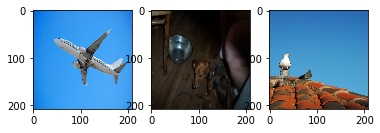

In [0]:
x_train, y_train = build_classification_dataset(train_files) #y_train is in the form of [[1 0 0 0 0] [1 0 0 0 0] ... ]
#print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))

x_val, y_val = build_classification_dataset(val_files)
#print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

# For the autoencoder only x_train and x_val are needed

# Display some images
plt.subplot(1,3,1)
plt.imshow(x_train[0])
plt.subplot(1,3,2)
plt.imshow(x_val[987])
plt.subplot(1,3,3)
plt.imshow(x_val[1230])
plt.show()

### First Autoencoder case 

* **Define the autoencoder architecture**
- **Coding Variables: 5832**

In [0]:
input_img = Input(shape = (212, 212, 3))


def auto_encode(input_img):
    #encoder
    #input = 212 x 212 x 3 (wide and thin)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1) 
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2)
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
    encoded = MaxPooling2D((2, 2), padding='same')(conv3)

    #decoder
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    up1 = UpSampling2D((2,2))(conv4) # 108, 108, 128
    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv5) # 216, 216, 64
    conv6 = Conv2D(16, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2,2))(conv6) # 216, 216, 64
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded


* **Build the model**

In [0]:
#Build the model
autoencoder = Model(input_img, auto_encode(input_img)) #create an object first

autoencoder.summary()
#plot_model(autoencoder, to_file='1st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 212, 212, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 106, 8)       1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 8)         0         
__________

* **Compile the model and train (loss='mean_squared_error', optimizer = RMSprop())**

In [0]:
#Compile the model and train
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train = autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, verbose=2, validation_data=(x_val, x_val))
#autoencoder.save("autoencoder_FirstTry.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
 - 5s - loss: 0.0700 - acc: 0.4315 - val_loss: 0.0605 - val_acc: 0.3309
Epoch 2/50
 - 4s - loss: 0.0551 - acc: 0.3080 - val_loss: 0.0419 - val_acc: 0.2617
Epoch 3/50
 - 4s - loss: 0.0375 - acc: 0.3402 - val_loss: 0.0285 - val_acc: 0.4707
Epoch 4/50
 - 4s - loss: 0.0310 - acc: 0.4198 - val_loss: 0.0274 - val_acc: 0.4522
Epoch 5/50
 - 4s - loss: 0.0268 - acc: 0.4255 - val_loss: 0.0247 - val_acc: 0.4617
Epoch 6/50
 - 4s - loss: 0.0259 - acc: 0.4504 - val_loss: 0.0239 - val_acc: 0.4510
Epoch 7/50
 - 4s - loss: 0.0235 - acc: 0.4763 - val_loss: 0.0223 - val_acc: 0.4949
Epoch 8/50
 - 4s - loss: 0.0228 - acc: 0.5070 - val_loss: 0.0209 - val_acc: 0.5282
Epoch 9/50
 - 4s - loss: 0.0216 - acc: 0.5530 - val_loss: 0.0196 - val_acc: 0.5603
Epoch 10/50
 - 4s - loss: 0.0205 - acc: 0.5762 - val_loss: 0.0185 - val_acc: 0.6132
Epoch 11/50
 - 4s - loss: 0.0198 - acc: 0.6018 - val_loss: 0.0185 - val_acc: 0.6175
Epoch 12/50
 - 4s - loss: 0.0194 - ac

* **Plot the loss plot between training and validation data to visualize the model performance**



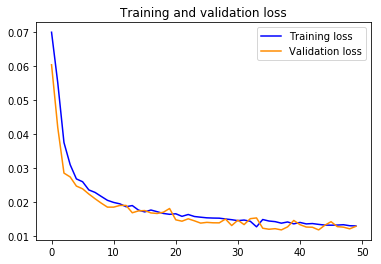

In [0]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

* **Generalize the autoencoder model**

In [0]:
# encode and decode the validation images
encodedDecoded_images = autoencoder.predict(x_val)

(-0.5, 211.5, 211.5, -0.5)

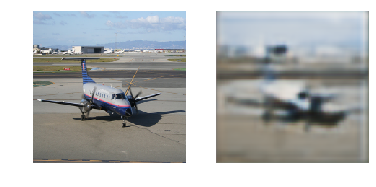

In [0]:
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images[90])
plt.axis('off')

In [0]:
#Reconstruction error for the test data
reconstr_error = mean_squared_error(x_val.flatten(),encodedDecoded_images.flatten())
print('MSE reconstruction error = %.2f' % reconstr_error)

MSE reconstruction error = 0.01


* **Train the same model for more epochs (200) and batch_size = 64**

In [0]:
#Build the model
autoencoder1 = Model(input_img, auto_encode(input_img)) #create an object first

autoencoder1.summary()
plot_model(autoencoder1, to_file='2nd.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 212, 212, 16)      448       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 106, 106, 8)       1160      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 27, 27, 8)         0         
__________

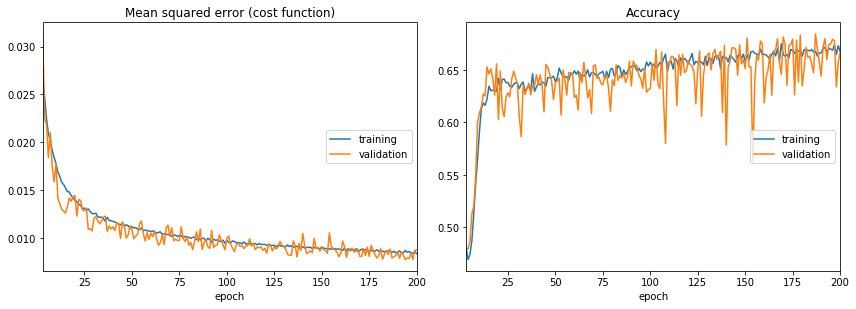

Mean squared error (cost function):
training   (min:    0.008, max:    0.059, cur:    0.008)
validation (min:    0.008, max:    0.037, cur:    0.009)

Accuracy:
training   (min:    0.459, max:    0.675, cur:    0.667)
validation (min:    0.480, max:    0.684, cur:    0.667)


In [0]:
#Compile the model and train
autoencoder1.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy'])
autoencoder_train_1 = autoencoder1.fit(x_train, x_train, epochs=200, batch_size=64, verbose=1, validation_data=(x_val, x_val),callbacks=[PlotLossesKeras()])
autoencoder1.save("autoencoder_2ndTry.h5")

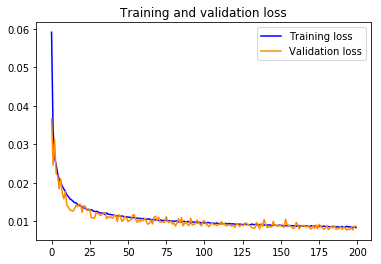

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_1.history['loss']
val_loss = autoencoder_train_1.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
# encode and decode the validation images
encodedDecoded_images_1 = autoencoder1.predict(x_val)

(-0.5, 211.5, 211.5, -0.5)

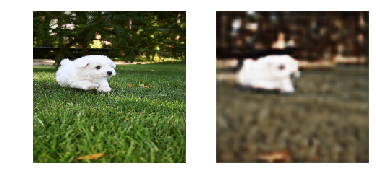

In [0]:
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[1110])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_1[1110])
plt.axis('off')

In [0]:
#Reconstruction error for the test data
reconstr_error_1 = mean_squared_error(x_val.flatten(),encodedDecoded_images_1.flatten())
print('MSE reconstruction error = %.2f' % reconstr_error_1)

MSE reconstruction error = 0.01


- **Train the same model for epochs=50 and batch_size = 256**

In [0]:
#Build the model
autoencoder256 = Model(input_img, auto_encode(input_img)) #create an object first

autoencoder256.summary()
#plot_model(autoencoder256, to_file='ThirdTry.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 212, 212, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 106, 106, 8)       1160      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 27, 27, 8)         0         
__________

In [0]:
#Compile the model and train
autoencoder256.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy'])
autoencoder_train_256 = autoencoder256.fit(x_train, x_train, epochs=50, batch_size=256, verbose=1, validation_data=(x_val, x_val))
#autoencoder256.save("autoencoder_ThirdTry.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 13s 9ms/step - loss: 0.0717 - acc: 0.4564 - val_loss: 0.0710 - val_acc: 0.4804
Epoch 2/50
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0659 - acc: 0.4193 - val_loss: 0.0585 - val_acc: 0.2457
Epoch 3/50
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0521 - acc: 0.3289 - val_loss: 0.0651 - val_acc: 0.2434
Epoch 4/50
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0489 - acc: 0.3641 - val_loss: 0.0313 - val_acc: 0.3655
Epoch 5/50
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0339 - acc: 0.3832 - val_loss: 0.0382 - val_acc: 0.4388
Epoch 6/50
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0302 - acc: 0.4169 - val_loss: 0.0381 - val_acc: 0.4604
Epoch 7/50
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0306 - acc: 0.4416 - val_loss: 0.0305 - val_acc: 0.4614
Epoch 8/50
14

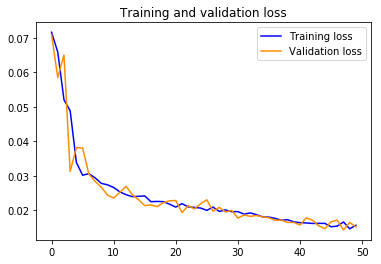

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_256.history['loss']
val_loss = autoencoder_train_256.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

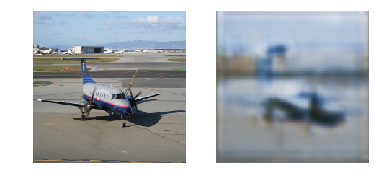

In [0]:
# encode and decode the validation images
encodedDecoded_images_256 = autoencoder256.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_256[90])
plt.axis('off')

- **Train the same autoencoder with different optimizer**

In [0]:
#Build the model
autoencoder2 = Model(input_img, auto_encode(input_img)) #create an object first

autoencoder2.summary()
plot_model(autoencoder2, to_file='ThirdTry.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 212, 212, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 106, 106, 8)       1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 8)         0         
__________

In [0]:
#Compile the model and train
autoencoder2.compile(loss='mean_squared_error', optimizer = 'sgd', metrics=['accuracy'])
autoencoder_train_2 = autoencoder2.fit(x_train, x_train, epochs=200, batch_size=64, verbose=1, validation_data=(x_val, x_val))
autoencoder2.save("autoencoder_ThirdTry.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0543 - acc: 0.3959 - val_loss: 0.0542 - val_acc: 0.4084
Epoch 2/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0537 - acc: 0.3980 - val_loss: 0.0535 - val_acc: 0.4119
Epoch 3/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0531 - acc: 0.4011 - val_loss: 0.0529 - val_acc: 0.4124
Epoch 4/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0524 - acc: 0.4025 - val_loss: 0.0523 - val_acc: 0.4157
Epoch 5/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0518 - acc: 0.4045 - val_loss: 0.0516 - val_acc: 0.4167
Epoch 6/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0511 - acc: 0.4068 - val_loss: 0.0510 - val_acc: 0.4187
Epoch 7/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0505 - acc: 0.4081 - val_loss: 0.0503 - val_acc: 0.4200
Epoch 8

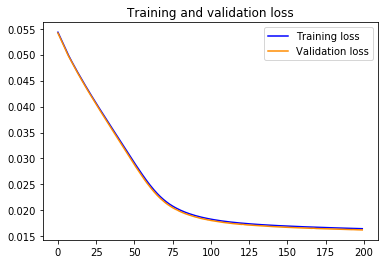

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_2.history['loss']
val_loss = autoencoder_train_2.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

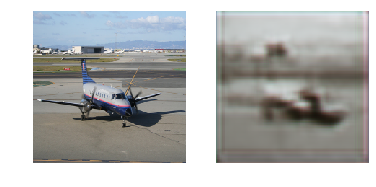

In [0]:
# encode and decode the validation images
encodedDecoded_images_2 = autoencoder2.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_2[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder4 = Model(input_img, auto_encode(input_img)) #create an object first

autoencoder4.summary()
plot_model(autoencoder4, to_file='FifthTry.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 212, 212, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 106, 106, 8)       1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 27, 27, 8)         0         
__________

In [0]:
#Compile the model and train
autoencoder4.compile(loss='mean_squared_error', optimizer = 'adadelta', metrics=['accuracy'])
autoencoder_train_4 = autoencoder4.fit(x_train, x_train, epochs=200, batch_size=64, verbose=1, validation_data=(x_val, x_val))
autoencoder4.save("autoencoder_FifthTry.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 5s 3ms/step - loss: 0.0711 - acc: 0.2528 - val_loss: 0.0652 - val_acc: 0.2330
Epoch 2/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0604 - acc: 0.3206 - val_loss: 0.0520 - val_acc: 0.3307
Epoch 3/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0493 - acc: 0.4218 - val_loss: 0.0662 - val_acc: 0.5074
Epoch 4/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0386 - acc: 0.4324 - val_loss: 0.0423 - val_acc: 0.4865
Epoch 5/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0308 - acc: 0.4419 - val_loss: 0.0332 - val_acc: 0.5020
Epoch 6/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0273 - acc: 0.4445 - val_loss: 0.0249 - val_acc: 0.4976
Epoch 7/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.0246 - acc: 0.4679 - val_loss: 0.0275 - val_acc: 0.5209
Epoch 8

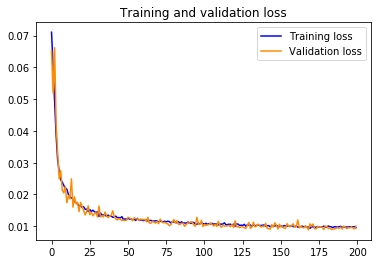

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_4.history['loss']
val_loss = autoencoder_train_4.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

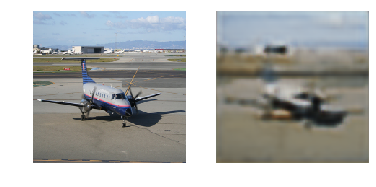

In [0]:
# encode and decode the validation images
encodedDecoded_images_4 = autoencoder4.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_4[90])
plt.axis('off')

* **Build the model with the same architecture but train it with different loss function and optimizer**

In [0]:
#Build the model
autoencoder5 = Model(input_img, auto_encode(input_img)) #create an object first

autoencoder5.summary()
plot_model(autoencoder5, to_file='5th.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 212, 212, 16)      448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 106, 106, 8)       1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 27, 27, 8)         0         
__________

In [0]:
#Compile the model and train
autoencoder5.compile(loss='mae', optimizer = RMSprop(), metrics=['accuracy'])
autoencoder_train_5 = autoencoder5.fit(x_train, x_train, epochs=200, batch_size=64, verbose=1, validation_data=(x_val, x_val))
autoencoder5.save("autoencoder_5th.h5")


Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 5s 3ms/step - loss: 0.2073 - acc: 0.5154 - val_loss: 0.1666 - val_acc: 0.5103
Epoch 2/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1433 - acc: 0.5172 - val_loss: 0.1196 - val_acc: 0.5378
Epoch 3/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1250 - acc: 0.5510 - val_loss: 0.1117 - val_acc: 0.5753
Epoch 4/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1166 - acc: 0.5931 - val_loss: 0.1265 - val_acc: 0.5838
Epoch 5/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1102 - acc: 0.6100 - val_loss: 0.1032 - val_acc: 0.6261
Epoch 6/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1043 - acc: 0.6270 - val_loss: 0.1018 - val_acc: 0.6329
Epoch 7/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1019 - acc: 0.6324 - val_loss: 0.1077 - val_acc: 0.6058
Epoch 8

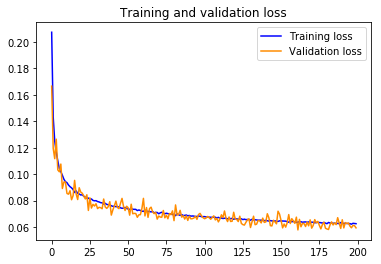

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_5.history['loss']
val_loss = autoencoder_train_5.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

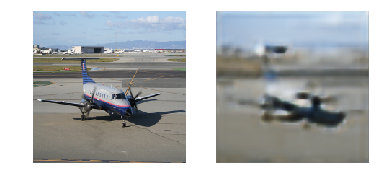

In [0]:
# encode and decode the validation images
encodedDecoded_images_5 = autoencoder5.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_5[90])
plt.axis('off')

In [0]:
#Reconstruction error for the test data
reconstr_error_5 = mean_squared_error(x_val.flatten(),encodedDecoded_images_5.flatten())
print('MSE reconstruction error = %.2f' % reconstr_error_5)

MSE reconstruction error = 0.01


In [0]:
#Build the model
autoencoder6 = Model(input_img, auto_encode(input_img)) #create an object first

autoencoder6.summary()
plot_model(autoencoder6, to_file='6th.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 212, 212, 16)      448       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 106, 106, 8)       1160      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 27, 27, 8)         0         
__________

In [0]:
#Compile the model and train
autoencoder6.compile(loss='mae', optimizer = 'sgd', metrics=['accuracy'])
autoencoder_train_6 = autoencoder6.fit(x_train, x_train, epochs=200, batch_size=64, verbose=1, validation_data=(x_val, x_val))
autoencoder6.save("autoencoder_6th.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 5s 3ms/step - loss: 0.2300 - acc: 0.2171 - val_loss: 0.2293 - val_acc: 0.2258
Epoch 2/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.2296 - acc: 0.2211 - val_loss: 0.2288 - val_acc: 0.2307
Epoch 3/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.2292 - acc: 0.2266 - val_loss: 0.2283 - val_acc: 0.2363
Epoch 4/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.2287 - acc: 0.2319 - val_loss: 0.2279 - val_acc: 0.2415
Epoch 5/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.2283 - acc: 0.2368 - val_loss: 0.2274 - val_acc: 0.2471
Epoch 6/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.2279 - acc: 0.2426 - val_loss: 0.2270 - val_acc: 0.2525
Epoch 7/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.2275 - acc: 0.2480 - val_loss: 0.2265 - val_acc: 0.2595
Epoch 8

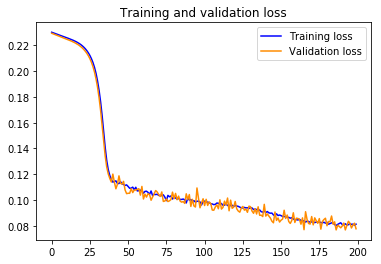

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_6.history['loss']
val_loss = autoencoder_train_6.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

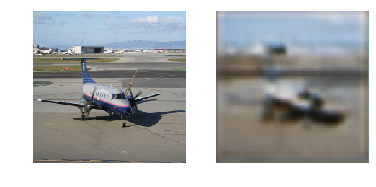

In [0]:
# encode and decode the validation images
encodedDecoded_images_6 = autoencoder6.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_6[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder7 = Model(input_img, auto_encode(input_img)) #create an object first

autoencoder7.summary()
plot_model(autoencoder7, to_file='7th.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 212, 212, 16)      448       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 106, 106, 16)      0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 106, 106, 8)       1160      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 53, 53, 8)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 53, 53, 8)         584       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 27, 27, 8)         0         
__________

In [0]:
#Compile the model and train
autoencoder7.compile(loss='mae', optimizer = 'adadelta', metrics=['accuracy'])
autoencoder_train_7 = autoencoder7.fit(x_train, x_train, epochs=200, batch_size=64, verbose=1, validation_data=(x_val, x_val))
autoencoder7.save("autoencoder_7th.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 5s 3ms/step - loss: 0.2226 - acc: 0.3765 - val_loss: 0.1842 - val_acc: 0.4793
Epoch 2/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1816 - acc: 0.3987 - val_loss: 0.2044 - val_acc: 0.3358
Epoch 3/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1480 - acc: 0.3943 - val_loss: 0.1537 - val_acc: 0.4035
Epoch 4/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1373 - acc: 0.4142 - val_loss: 0.1563 - val_acc: 0.4352
Epoch 5/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1318 - acc: 0.4232 - val_loss: 0.1161 - val_acc: 0.4112
Epoch 6/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1229 - acc: 0.4253 - val_loss: 0.1221 - val_acc: 0.4147
Epoch 7/200
1489/1489 [==============================] - 4s 3ms/step - loss: 0.1224 - acc: 0.4344 - val_loss: 0.1225 - val_acc: 0.4399
Epoch 8

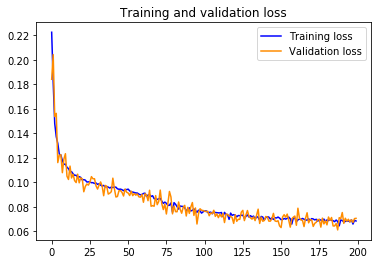

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_7.history['loss']
val_loss = autoencoder_train_7.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

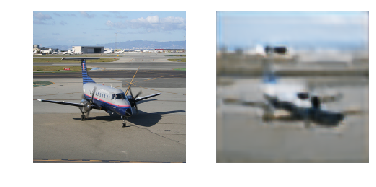

In [0]:
# encode and decode the validation images
encodedDecoded_images_7 = autoencoder7.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_7[90])
plt.axis('off')

(-0.5, 211.5, 211.5, -0.5)

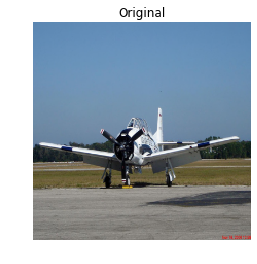

In [0]:
plt.title('Original')
plt.imshow(x_val[0])
plt.axis('off')

(-0.5, 211.5, 211.5, -0.5)

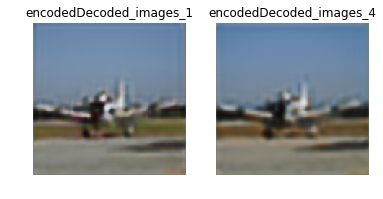

In [0]:
plt.subplot(121)
plt.title('encodedDecoded_images_1')
plt.imshow(encodedDecoded_images_1[0])
plt.axis('off')
plt.subplot(122)
plt.title('encodedDecoded_images_4')
plt.imshow(encodedDecoded_images_4[0])
plt.axis('off')

(-0.5, 211.5, 211.5, -0.5)

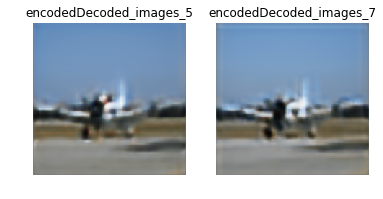

In [0]:
plt.subplot(121)
plt.title('encodedDecoded_images_5')
plt.imshow(encodedDecoded_images_5[0])
plt.axis('off')
plt.subplot(122)
plt.title('encodedDecoded_images_7')
plt.imshow(encodedDecoded_images_7[0])
plt.axis('off')

### Another autoencoder architecture

* **Define the autoencoder architecture**
- **Coding Variables: 392**

In [0]:
input_img = Input(shape = (212, 212, 3))


def auto_encode_2(input_img):
    #encoder
    #input = 212 x 212 x 3
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1) 
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2) 
    conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D((2, 2), padding='same')(conv3) 
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2), padding='same')(conv4) 
    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool4) 
    encoded = MaxPooling2D((2, 2), padding='same')(conv5)

    #decoder
    conv6 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded) 
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv7)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2,2))(conv8)
    conv9 = Conv2D(32, (3, 3), activation='relu')(up3)
    up4 = UpSampling2D((2,2))(conv9)
    conv10 = Conv2D(64, (3, 3), activation='relu')(up4)
    up5 = UpSampling2D((2,2))(conv10)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up5)
    return decoded

In [0]:
#Build the model
autoencoder_21 = Model(input_img, auto_encode_2(input_img)) 

autoencoder_21.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 212, 212, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 106, 106, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 106, 106, 32)      18464     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 53, 53, 16)        4624      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 16)        0         
__________

- **Epochs=200, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_21.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_21 = autoencoder_21.fit(x_train, x_train, epochs=200, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 14s 10ms/step - loss: 0.0704 - acc: 0.4747 - val_loss: 0.0695 - val_acc: 0.4991
Epoch 2/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0708 - acc: 0.4829 - val_loss: 0.0606 - val_acc: 0.5004
Epoch 3/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0577 - acc: 0.4366 - val_loss: 0.0425 - val_acc: 0.4803
Epoch 4/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0486 - acc: 0.4222 - val_loss: 0.0382 - val_acc: 0.4338
Epoch 5/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0435 - acc: 0.4025 - val_loss: 0.1020 - val_acc: 0.2782
Epoch 6/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0438 - acc: 0.4004 - val_loss: 0.0335 - val_acc: 0.4337
Epoch 7/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0397 - acc: 0.4178 - val_loss: 0.0347 - val_acc: 0.4580
Epoch

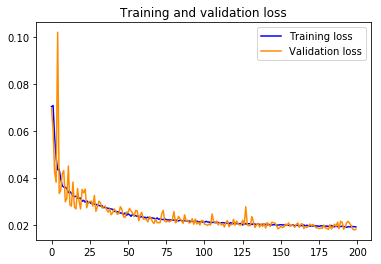

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_21.history['loss']
val_loss = autoencoder_train_21.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

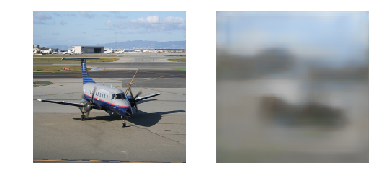

In [0]:
# encode and decode the validation images
encodedDecoded_images_21 = autoencoder_21.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_21[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder_22 = Model(input_img, auto_encode_2(input_img)) 

autoencoder_22.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 212, 212, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 106, 106, 64)      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 106, 106, 32)      18464     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 53, 53, 16)        4624      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 27, 27, 16)        0         
__________

- **Epochs=50, batch_size=128, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_22.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_22 = autoencoder_22.fit(x_train, x_train, epochs=50, batch_size=128, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 19s 12ms/step - loss: 0.0728 - acc: 0.4032 - val_loss: 0.0704 - val_acc: 0.5014
Epoch 2/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0623 - acc: 0.5005 - val_loss: 0.1222 - val_acc: 0.5023
Epoch 3/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0566 - acc: 0.4923 - val_loss: 0.0645 - val_acc: 0.4064
Epoch 4/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0471 - acc: 0.4714 - val_loss: 0.0413 - val_acc: 0.4431
Epoch 5/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0430 - acc: 0.4361 - val_loss: 0.0402 - val_acc: 0.3911
Epoch 6/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0431 - acc: 0.4038 - val_loss: 0.0439 - val_acc: 0.3902
Epoch 7/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0411 - acc: 0.4193 - val_loss: 0.0382 - val_acc: 0.3950
Epoch 8/50
1

(-0.5, 211.5, 211.5, -0.5)

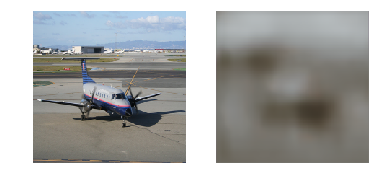

In [0]:
# encode and decode the validation images
encodedDecoded_images_22 = autoencoder_22.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_22[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder_23 = Model(input_img, auto_encode_2(input_img)) 

autoencoder_23.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 212, 212, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 106, 106, 64)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 106, 106, 32)      18464     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 53, 53, 16)        4624      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 27, 27, 16)        0         
__________

In [0]:
#Compile the model and train
autoencoder_23.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_23 = autoencoder_23.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0701 - acc: 0.4613 - val_loss: 0.0560 - val_acc: 0.5012
Epoch 2/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0598 - acc: 0.4985 - val_loss: 0.0432 - val_acc: 0.5014
Epoch 3/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0456 - acc: 0.4813 - val_loss: 0.0364 - val_acc: 0.4186
Epoch 4/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0419 - acc: 0.4443 - val_loss: 0.0406 - val_acc: 0.3503
Epoch 5/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0393 - acc: 0.3948 - val_loss: 0.0409 - val_acc: 0.4806
Epoch 6/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0367 - acc: 0.4069 - val_loss: 0.0349 - val_acc: 0.4550
Epoch 7/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0359 - acc: 0.4047 - val_loss: 0.0377 - val_acc: 0.4659
Epoch 8/50
14

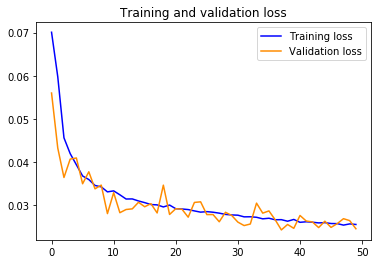

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_23.history['loss']
val_loss = autoencoder_train_23.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

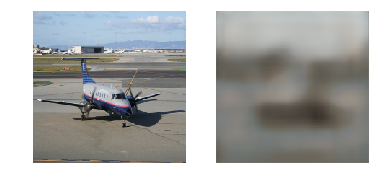

In [0]:
# encode and decode the validation images
encodedDecoded_images_23 = autoencoder_23.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_23[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder_25 = Model(input_img, auto_encode_2(input_img)) 

autoencoder_25.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 212, 212, 64)      1792      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 106, 106, 64)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 106, 106, 32)      18464     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 53, 53, 16)        4624      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 27, 27, 16)        0         
__________

- **Epochs=50, batch_size=128, loss=mae, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_25.compile(loss='mae', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_25 = autoencoder_25.fit(x_train, x_train, epochs=50, batch_size=128, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.2283 - acc: 0.4935 - val_loss: 0.2246 - val_acc: 0.4986
Epoch 2/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.2175 - acc: 0.4960 - val_loss: 0.2108 - val_acc: 0.4990
Epoch 3/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.2026 - acc: 0.4511 - val_loss: 0.1757 - val_acc: 0.4539
Epoch 4/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.1722 - acc: 0.4179 - val_loss: 0.1634 - val_acc: 0.3694
Epoch 5/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.1686 - acc: 0.4001 - val_loss: 0.1472 - val_acc: 0.4646
Epoch 6/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.1577 - acc: 0.4559 - val_loss: 0.1765 - val_acc: 0.4203
Epoch 7/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.1567 - acc: 0.4611 - val_loss: 0.1551 - val_acc: 0.4421
Epoch 8/50
14

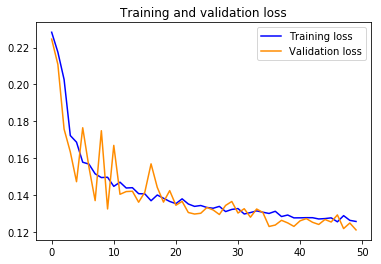

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_25.history['loss']
val_loss = autoencoder_train_25.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

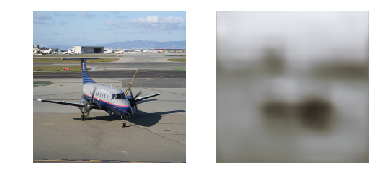

In [0]:
# encode and decode the validation images
encodedDecoded_images_25 = autoencoder_25.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_25[90])
plt.axis('off')

### New option for autoencoder

* **Define the autoencoder architecture**
- **Coding Variables: 1568**

In [0]:
input_img = Input(shape = (212, 212, 3))


def auto_encode_3(input_img):
    #encoder
    #input = 212 x 212 x 3
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1) 
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2) 
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2), padding='same')(conv3) 
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool3) 
    encoded = MaxPooling2D((2, 2), padding='same')(conv4)

    #decoder
    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(16, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2,2))(conv7)
    conv8 = Conv2D(32, (3, 3), activation='relu')(up3)
    up4 = UpSampling2D((2,2))(conv8)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)
    return decoded

In [0]:
#Build the model
autoencoder_31 = Model(input_img, auto_encode_3(input_img)) 

autoencoder_31.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 212, 212, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 106, 106, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 106, 106, 16)      4624      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 53, 53, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 53, 53, 8)         1160      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 27, 27, 8)         0         
__________

- **Epochs=50, batch_size=128, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_31.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_31 = autoencoder_31.fit(x_train, x_train, epochs=50, batch_size=128, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

W0827 19:42:57.403234 139701878101888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 19:42:57.675956 139701878101888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0827 19:42:57.683052 139701878101888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 20s 14ms/step - loss: 0.0740 - acc: 0.3422 - val_loss: 0.0556 - val_acc: 0.4286
Epoch 2/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0495 - acc: 0.4165 - val_loss: 0.0358 - val_acc: 0.4377
Epoch 3/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0432 - acc: 0.4137 - val_loss: 0.0470 - val_acc: 0.4733
Epoch 4/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0374 - acc: 0.4191 - val_loss: 0.0307 - val_acc: 0.4362
Epoch 5/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0324 - acc: 0.4107 - val_loss: 0.0350 - val_acc: 0.4645
Epoch 6/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0337 - acc: 0.4121 - val_loss: 0.0265 - val_acc: 0.4285
Epoch 7/50
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0311 - acc: 0.4160 - val_loss: 0.0252 - val_acc: 0.4357
Epoch 8/50
1

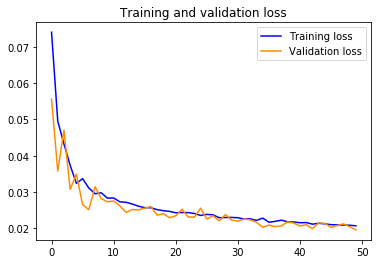

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_31.history['loss']
val_loss = autoencoder_train_31.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

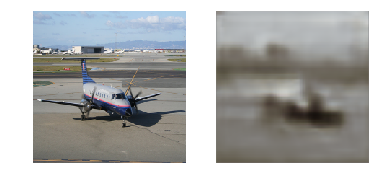

In [0]:
# encode and decode the validation images
encodedDecoded_images_31 = autoencoder_31.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_31[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder_32 = Model(input_img, auto_encode_3(input_img)) 

autoencoder_32.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 212, 212, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 106, 106, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 106, 106, 16)      4624      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 53, 53, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 53, 53, 8)         1160      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 27, 27, 8)         0         
__________

- **Epochs=50, batch_size=256, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_32.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_32 = autoencoder_32.fit(x_train, x_train, epochs=50, batch_size=256, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 21s 14ms/step - loss: 0.0718 - acc: 0.4468 - val_loss: 0.0600 - val_acc: 0.4209
Epoch 2/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0620 - acc: 0.4148 - val_loss: 0.0440 - val_acc: 0.4277
Epoch 3/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0561 - acc: 0.3951 - val_loss: 0.0388 - val_acc: 0.4370
Epoch 4/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0426 - acc: 0.4097 - val_loss: 0.0374 - val_acc: 0.4220
Epoch 5/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0352 - acc: 0.3991 - val_loss: 0.0435 - val_acc: 0.4578
Epoch 6/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0393 - acc: 0.3919 - val_loss: 0.0302 - val_acc: 0.4231
Epoch 7/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0379 - acc: 0.3903 - val_loss: 0.0306 - val_acc: 0.4377
Epoch 

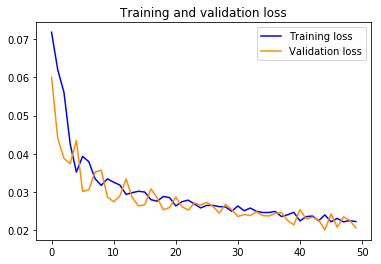

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_32.history['loss']
val_loss = autoencoder_train_32.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

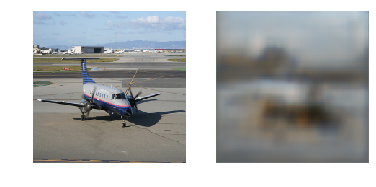

In [0]:
# encode and decode the validation images
encodedDecoded_images_32 = autoencoder_32.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_32[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder_33 = Model(input_img, auto_encode_3(input_img)) 

autoencoder_33.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 212, 212, 32)      896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 106, 106, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 106, 106, 16)      4624      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 53, 53, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 53, 53, 8)         1160      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 27, 27, 8)         0         
__________

- **Epochs=200, batch_size=128, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_33.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_33 = autoencoder_33.fit(x_train, x_train, epochs=200, batch_size=128, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0712 - acc: 0.4529 - val_loss: 0.0573 - val_acc: 0.4817
Epoch 2/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0474 - acc: 0.4112 - val_loss: 0.0408 - val_acc: 0.3499
Epoch 3/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0432 - acc: 0.3776 - val_loss: 0.0332 - val_acc: 0.4227
Epoch 4/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0348 - acc: 0.3894 - val_loss: 0.0286 - val_acc: 0.4007
Epoch 5/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0334 - acc: 0.4034 - val_loss: 0.0289 - val_acc: 0.3864
Epoch 6/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0341 - acc: 0.3942 - val_loss: 0.0311 - val_acc: 0.3954
Epoch 7/200
1489/1489 [==============================] - 9s 6ms/step - loss: 0.0307 - acc: 0.4234 - val_loss: 0.0273 - val_acc: 0.4107
Epoch 

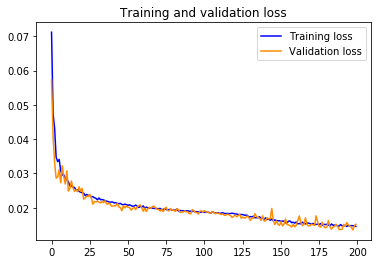

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_33.history['loss']
val_loss = autoencoder_train_33.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

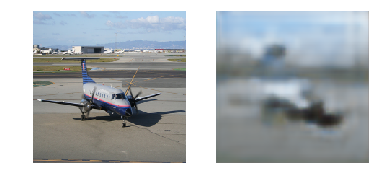

In [0]:
# encode and decode the validation images
encodedDecoded_images_33 = autoencoder_33.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_33[90])
plt.axis('off')

In [0]:
# encode and decode the validation images
encodedDecoded_images_33 = autoencoder_33.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_33[90])
plt.axis('off')

### Another autoencoder architecture

- **Coding Variables: 5832**

In [0]:
input_img = Input(shape = (212, 212, 3))


def auto_encode_4(input_img):
    #encoder
    #input = 214 x 214 x 3
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1) 
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2) 
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2), padding='same')(conv3) 
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(pool3)

    #decoder
    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(16, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2,2))(conv7)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded

In [0]:
#Build the model
autoencoder_41 = Model(input_img, auto_encode_4(input_img)) 

autoencoder_41.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 212, 212, 32)      896       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 106, 106, 32)      0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 106, 106, 16)      4624      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 53, 53, 16)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 53, 53, 8)         1160      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 27, 27, 8)         0         
__________

- **Epochs=200, batch_size=128, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_41.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_41 = autoencoder_41.fit(x_train, x_train, epochs=200, batch_size=128, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 11s 7ms/step - loss: 0.0676 - acc: 0.3848 - val_loss: 0.0655 - val_acc: 0.3598
Epoch 2/200
1489/1489 [==============================] - 8s 5ms/step - loss: 0.0551 - acc: 0.4158 - val_loss: 0.0330 - val_acc: 0.4326
Epoch 3/200
1489/1489 [==============================] - 8s 5ms/step - loss: 0.0348 - acc: 0.4268 - val_loss: 0.0279 - val_acc: 0.4370
Epoch 4/200
1489/1489 [==============================] - 8s 5ms/step - loss: 0.0306 - acc: 0.4197 - val_loss: 0.0318 - val_acc: 0.4167
Epoch 5/200
1489/1489 [==============================] - 8s 5ms/step - loss: 0.0303 - acc: 0.4164 - val_loss: 0.0231 - val_acc: 0.4291
Epoch 6/200
1489/1489 [==============================] - 8s 5ms/step - loss: 0.0268 - acc: 0.4251 - val_loss: 0.0211 - val_acc: 0.4640
Epoch 7/200
1489/1489 [==============================] - 8s 5ms/step - loss: 0.0257 - acc: 0.4397 - val_loss: 0.0199 - val_acc: 0.4469
Epoch 

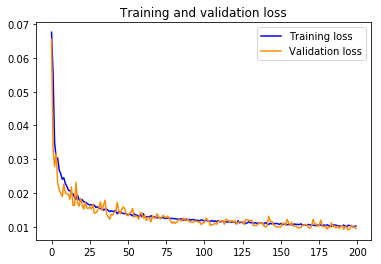

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_41.history['loss']
val_loss = autoencoder_train_41.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

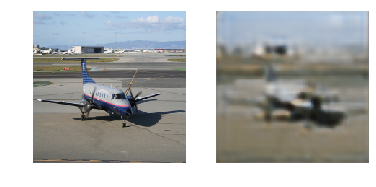

In [0]:
# encode and decode the validation images
encodedDecoded_images_41 = autoencoder_41.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_41[90])
plt.axis('off')

### New option for autoencoder architecture

- **Coding variables:1568**

In [0]:
input_img = Input(shape = (212, 212, 3))


def auto_encode_5(input_img):
    #encoder
    #input = 212 x 212 x 3
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1) 
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2) 
    conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D((2, 2), padding='same')(conv3) 
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2), padding='same')(conv4) 
    encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(pool4)

    #decoder
    conv6 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded) 
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv7)
    conv8 = Conv2D(16, (3, 3), activation='relu')(up2)
    up3 = UpSampling2D((2,2))(conv8)
    conv9 = Conv2D(32, (3, 3), activation='relu')(up3)
    up4 = UpSampling2D((2,2))(conv9)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)
    return decoded

In [0]:
#Build the model
autoencoder_51 = Model(input_img, auto_encode_5(input_img)) 

autoencoder_51.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 212, 212, 64)      1792      
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 106, 106, 64)      0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 106, 106, 32)      18464     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 53, 53, 16)        4624      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 27, 27, 16)        0         
__________

- **Epochs=200, batch_size=128, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_51.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_51 = autoencoder_51.fit(x_train, x_train, epochs=200, batch_size=128, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 17s 11ms/step - loss: 0.0707 - acc: 0.4911 - val_loss: 0.0596 - val_acc: 0.4901
Epoch 2/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.0577 - acc: 0.4705 - val_loss: 0.0460 - val_acc: 0.4964
Epoch 3/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.0476 - acc: 0.4941 - val_loss: 0.0660 - val_acc: 0.4969
Epoch 4/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.0443 - acc: 0.4901 - val_loss: 0.0343 - val_acc: 0.4926
Epoch 5/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.0422 - acc: 0.4838 - val_loss: 0.0307 - val_acc: 0.4837
Epoch 6/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.0355 - acc: 0.4787 - val_loss: 0.0332 - val_acc: 0.4842
Epoch 7/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.0344 - acc: 0.4724 - val_loss: 0.0303 - val_acc: 0.4750

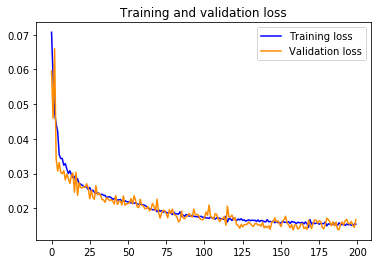

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_51.history['loss']
val_loss = autoencoder_train_51.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

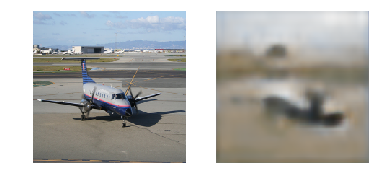

In [0]:
# encode and decode the validation images
encodedDecoded_images_51 = autoencoder_51.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_51[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder_52 = Model(input_img, auto_encode_5(input_img)) 

autoencoder_52.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 212, 212, 3)       0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 212, 212, 64)      1792      
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 106, 106, 64)      0         
_________________________________________________________________
conv2d_160 (Conv2D)          (None, 106, 106, 32)      18464     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 53, 53, 16)        4624      
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 27, 27, 16)        0         
__________

- **Epochs=200, batch_size=128, loss=mae, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_52.compile(loss='mae', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_52 = autoencoder_52.fit(x_train, x_train, epochs=200, batch_size=128, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 13s 9ms/step - loss: 0.2292 - acc: 0.4705 - val_loss: 0.2187 - val_acc: 0.4989
Epoch 2/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.2050 - acc: 0.4952 - val_loss: 0.1711 - val_acc: 0.4990
Epoch 3/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.1735 - acc: 0.4939 - val_loss: 0.1479 - val_acc: 0.4959
Epoch 4/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.1553 - acc: 0.4869 - val_loss: 0.1370 - val_acc: 0.4778
Epoch 5/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.1478 - acc: 0.4693 - val_loss: 0.1286 - val_acc: 0.4872
Epoch 6/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.1426 - acc: 0.4651 - val_loss: 0.1316 - val_acc: 0.4670
Epoch 7/200
1489/1489 [==============================] - 12s 8ms/step - loss: 0.1368 - acc: 0.4573 - val_loss: 0.1380 - val_acc: 0.4701


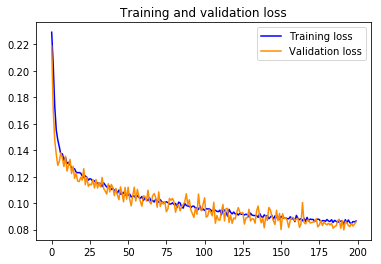

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_52.history['loss']
val_loss = autoencoder_train_52.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 211.5, 211.5, -0.5)

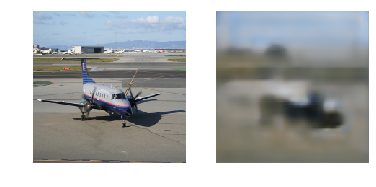

In [0]:
# encode and decode the validation images
encodedDecoded_images_52 = autoencoder_52.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_52[90])
plt.axis('off')

### Another autoencoder architecture

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_6(input_img):
    
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    pool4 = MaxPooling2D((2, 2), padding='same')(conv4)
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool4) 
    pool5 = MaxPooling2D((2, 2), padding='same')(conv5) 
    conv6 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool5)
    #pool6 = MaxPooling2D((2, 2), padding='same')(conv6) 
    #encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(pool6)
    
    
    #decoder
    #conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv6) 
    #up1 = UpSampling2D((2,2))(conv7) 
    conv8 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv6)
    up2 = UpSampling2D((2,2))(conv8)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv5)
    up3 = UpSampling2D((2,2))(conv9)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3) 
    up4 = UpSampling2D((2,2))(conv10) 
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4) 
    up5 = UpSampling2D((2,2))(conv11) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5) 
    up6 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up6) 
    return decoded
  
  
  


In [0]:
#Build the model
autoencoder_61 = Model(input_img, auto_encode_6(input_img)) 

autoencoder_61.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_747 (Conv2D)          (None, 208, 208, 256)     7168      
_________________________________________________________________
max_pooling2d_319 (MaxPoolin (None, 104, 104, 256)     0         
_________________________________________________________________
conv2d_748 (Conv2D)          (None, 104, 104, 128)     295040    
_________________________________________________________________
max_pooling2d_320 (MaxPoolin (None, 52, 52, 128)       0         
_________________________________________________________________
conv2d_749 (Conv2D)          (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_321 (MaxPoolin (None, 26, 26, 64)        0         
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_61.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_61 = autoencoder_61.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 50s 34ms/step - loss: 0.0704 - acc: 0.4039 - val_loss: 0.0651 - val_acc: 0.4872
Epoch 2/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0634 - acc: 0.4790 - val_loss: 0.0646 - val_acc: 0.4871
Epoch 3/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0469 - acc: 0.4801 - val_loss: 0.0301 - val_acc: 0.4447
Epoch 4/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0402 - acc: 0.4365 - val_loss: 0.0368 - val_acc: 0.4689
Epoch 5/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0351 - acc: 0.4227 - val_loss: 0.0459 - val_acc: 0.4990
Epoch 6/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0320 - acc: 0.4503 - val_loss: 0.0357 - val_acc: 0.4109
Epoch 7/50
1489/1489 [==============================] - 42s 28ms/step - loss: 0.0313 - acc: 0.4318 - val_loss: 0.0258 - val_acc: 0.5027


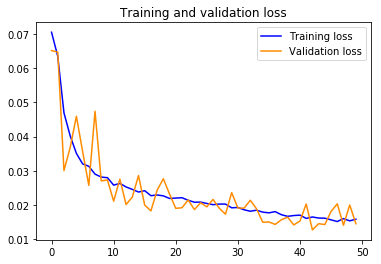

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_61.history['loss']
val_loss = autoencoder_train_61.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

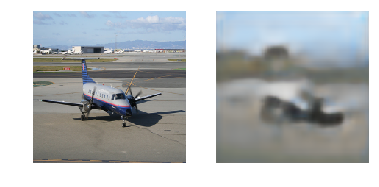

In [0]:
# encode and decode the validation images
encodedDecoded_images_61 = autoencoder_61.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_61[90])
plt.axis('off')

In [0]:
#Build the model
autoencoder_62 = Model(input_img, auto_encode_6(input_img)) 

autoencoder_62.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_759 (Conv2D)          (None, 208, 208, 256)     7168      
_________________________________________________________________
max_pooling2d_324 (MaxPoolin (None, 104, 104, 256)     0         
_________________________________________________________________
conv2d_760 (Conv2D)          (None, 104, 104, 128)     295040    
_________________________________________________________________
max_pooling2d_325 (MaxPoolin (None, 52, 52, 128)       0         
_________________________________________________________________
conv2d_761 (Conv2D)          (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_326 (MaxPoolin (None, 26, 26, 64)        0         
__________

- **Epochs=200, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_62.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_62 = autoencoder_62.fit(x_train, x_train, epochs=200, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/200
1489/1489 [==============================] - 45s 30ms/step - loss: 0.0785 - acc: 0.4514 - val_loss: 0.0514 - val_acc: 0.5009
Epoch 2/200
1489/1489 [==============================] - 42s 29ms/step - loss: 0.0459 - acc: 0.4616 - val_loss: 0.0846 - val_acc: 0.4778
Epoch 3/200
1489/1489 [==============================] - 42s 28ms/step - loss: 0.0409 - acc: 0.4586 - val_loss: 0.0281 - val_acc: 0.3945
Epoch 4/200
1489/1489 [==============================] - 42s 28ms/step - loss: 0.0364 - acc: 0.4223 - val_loss: 0.0266 - val_acc: 0.4254
Epoch 5/200
1489/1489 [==============================] - 42s 28ms/step - loss: 0.0330 - acc: 0.4364 - val_loss: 0.0264 - val_acc: 0.4610
Epoch 6/200
1489/1489 [==============================] - 42s 29ms/step - loss: 0.0327 - acc: 0.4447 - val_loss: 0.0240 - val_acc: 0.4528
Epoch 7/200
1489/1489 [==============================] - 42s 28ms/step - loss: 0.0307 - acc: 0.4630 - val_loss: 0.0232 - val_acc: 

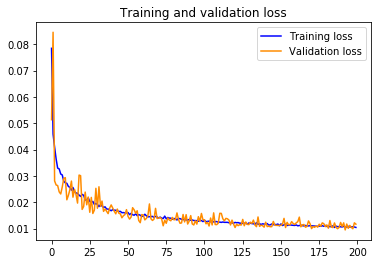

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_62.history['loss']
val_loss = autoencoder_train_62.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

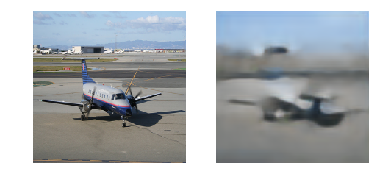

In [0]:
# encode and decode the validation images
encodedDecoded_images_62 = autoencoder_62.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_62[90])
plt.axis('off')

### New autoencoder architecture

- **Coding Variables: 5408**

In [0]:
input_img = Input(shape = (208, 208, 3))


def auto_encode_7(input_img):
    #encoder
    #input = 212 x 212 x 3 (wide and thin)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv2) 
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv3)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv4)
    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
    conv6 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv5)
    encoded = MaxPooling2D((2, 2), padding='same')(conv6)

    #decoder
    conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    conv8 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv7)
    up1 = UpSampling2D((2,2))(conv8) # 108, 108, 128
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
    conv10 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9) 
    up2 = UpSampling2D((2,2))(conv10) # 216, 216, 64
    conv11 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    conv12 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv11)
    up3 = UpSampling2D((2,2))(conv12) # 216, 216, 64
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded


In [0]:
#Build the model
autoencoder_71 = Model(input_img, auto_encode_7(input_img)) 

autoencoder_71.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_810 (Conv2D)          (None, 208, 208, 16)      448       
_________________________________________________________________
conv2d_811 (Conv2D)          (None, 208, 208, 16)      2320      
_________________________________________________________________
max_pooling2d_338 (MaxPoolin (None, 104, 104, 16)      0         
_________________________________________________________________
conv2d_812 (Conv2D)          (None, 104, 104, 8)       1160      
_________________________________________________________________
conv2d_813 (Conv2D)          (None, 104, 104, 8)       584       
_________________________________________________________________
max_pooling2d_339 (MaxPoolin (None, 52, 52, 8)         0         
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_71.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_71 = autoencoder_71.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 13s 8ms/step - loss: 0.0112 - acc: 0.5990 - val_loss: 0.0106 - val_acc: 0.6026
Epoch 2/50
1489/1489 [==============================] - 10s 6ms/step - loss: 0.0100 - acc: 0.5965 - val_loss: 0.0094 - val_acc: 0.6043
Epoch 3/50
1489/1489 [==============================] - 10s 7ms/step - loss: 0.0097 - acc: 0.5998 - val_loss: 0.0086 - val_acc: 0.6302
Epoch 4/50
1489/1489 [==============================] - 10s 6ms/step - loss: 0.0100 - acc: 0.6045 - val_loss: 0.0098 - val_acc: 0.6235
Epoch 5/50
1489/1489 [==============================] - 10s 6ms/step - loss: 0.0100 - acc: 0.5973 - val_loss: 0.0089 - val_acc: 0.5610
Epoch 6/50
1489/1489 [==============================] - 10s 6ms/step - loss: 0.0098 - acc: 0.6094 - val_loss: 0.0093 - val_acc: 0.5626
Epoch 7/50
1489/1489 [==============================] - 10s 6ms/step - loss: 0.0098 - acc: 0.6019 - val_loss: 0.0089 - val_acc: 0.6125
Epoch 8

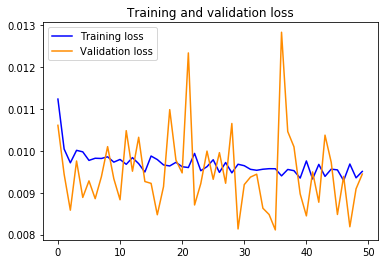

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_71.history['loss']
val_loss = autoencoder_train_71.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

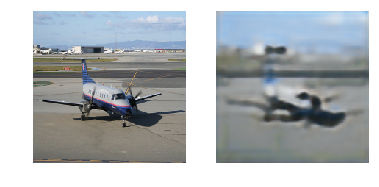

In [0]:
# encode and decode the validation images
encodedDecoded_images_71 = autoencoder_71.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_71[90])
plt.axis('off')

### Autoencoder architecture

- **Coding Variables: 21632**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_8(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3) 


    #decoder
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4) 
    up1 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) 
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2) 
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

In [0]:
#Build the model
autoencoder_81 = Model(input_img, auto_encode_8(input_img)) 

autoencoder_81.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_837 (Conv2D)          (None, 208, 208, 256)     7168      
_________________________________________________________________
max_pooling2d_347 (MaxPoolin (None, 104, 104, 256)     0         
_________________________________________________________________
conv2d_838 (Conv2D)          (None, 104, 104, 128)     295040    
_________________________________________________________________
max_pooling2d_348 (MaxPoolin (None, 52, 52, 128)       0         
_________________________________________________________________
conv2d_839 (Conv2D)          (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_349 (MaxPoolin (None, 26, 26, 64)        0         
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_81.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_81 = autoencoder_81.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 45s 31ms/step - loss: 0.0734 - acc: 0.3606 - val_loss: 0.0640 - val_acc: 0.4492
Epoch 2/50
1489/1489 [==============================] - 42s 28ms/step - loss: 0.0563 - acc: 0.4352 - val_loss: 0.0254 - val_acc: 0.4855
Epoch 3/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0363 - acc: 0.4367 - val_loss: 0.0303 - val_acc: 0.4227
Epoch 4/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0320 - acc: 0.4261 - val_loss: 0.0265 - val_acc: 0.4063
Epoch 5/50
1489/1489 [==============================] - 42s 29ms/step - loss: 0.0299 - acc: 0.4347 - val_loss: 0.0224 - val_acc: 0.4208
Epoch 6/50
1489/1489 [==============================] - 42s 28ms/step - loss: 0.0267 - acc: 0.4268 - val_loss: 0.0294 - val_acc: 0.3938
Epoch 7/50
1489/1489 [==============================] - 42s 29ms/step - loss: 0.0248 - acc: 0.4265 - val_loss: 0.0368 - val_acc: 0.4506


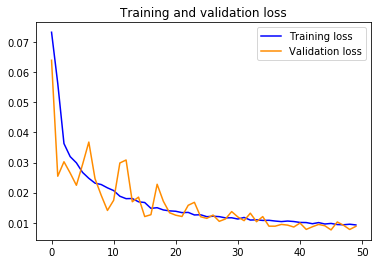

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_81.history['loss']
val_loss = autoencoder_train_81.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

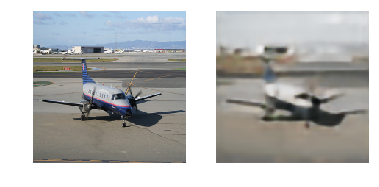

In [0]:
# encode and decode the validation images
encodedDecoded_images_81 = autoencoder_81.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_81[90])
plt.axis('off')

### New Autoencoder

- **Coding Variables: 692224**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_9(input_img):

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded
  

In [0]:
#Build the model
autoencoder_91 = Model(input_img, auto_encode_9(input_img)) 

autoencoder_91.summary()
#plot_model(autoencoder_21, to_file='21_st.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_81 (InputLayer)        (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_884 (Conv2D)          (None, 208, 208, 32)      896       
_________________________________________________________________
batch_normalization_37 (Batc (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_885 (Conv2D)          (None, 208, 208, 32)      9248      
_________________________________________________________________
batch_normalization_38 (Batc (None, 208, 208, 32)      128       
_________________________________________________________________
max_pooling2d_356 (MaxPoolin (None, 104, 104, 32)      0         
_________________________________________________________________
conv2d_886 (Conv2D)          (None, 104, 104, 64)      18496     
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_91.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_91 = autoencoder_91.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 61s 41ms/step - loss: 0.0408 - acc: 0.4657 - val_loss: 0.0355 - val_acc: 0.3705
Epoch 2/50
1489/1489 [==============================] - 41s 27ms/step - loss: 0.0185 - acc: 0.4965 - val_loss: 0.0439 - val_acc: 0.3835
Epoch 3/50
1489/1489 [==============================] - 41s 27ms/step - loss: 0.0172 - acc: 0.4846 - val_loss: 0.0613 - val_acc: 0.4063
Epoch 4/50
1489/1489 [==============================] - 41s 27ms/step - loss: 0.0151 - acc: 0.4872 - val_loss: 0.0988 - val_acc: 0.4320
Epoch 5/50
1489/1489 [==============================] - 41s 27ms/step - loss: 0.0140 - acc: 0.5135 - val_loss: 0.1045 - val_acc: 0.4210
Epoch 6/50
1489/1489 [==============================] - 41s 27ms/step - loss: 0.0117 - acc: 0.5349 - val_loss: 0.0734 - val_acc: 0.4798
Epoch 7/50
1489/1489 [==============================] - 41s 27ms/step - loss: 0.0113 - acc: 0.5484 - val_loss: 0.2083 - val_acc: 0.4602


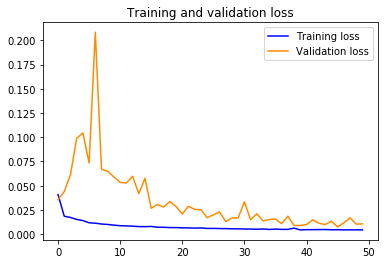

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_91.history['loss']
val_loss = autoencoder_train_91.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

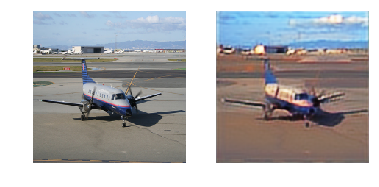

In [0]:
# encode and decode the validation images
encodedDecoded_images_91 = autoencoder_91.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_91[90])
plt.axis('off')

### Autoencoder Architecture

- **Coding Variables: 692224**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_10(input_img):

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    up1 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    up2 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [0]:
#Build the model
autoencoder_10_1 = Model(input_img, auto_encode_10(input_img)) 

autoencoder_10_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 208, 208, 32)      896       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 208, 208, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 104, 104, 32)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 104, 104, 64)      18496     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 104, 104, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 52, 52, 64)        0         
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_10_1.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_10_1 = autoencoder_10_1.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 33s 22ms/step - loss: 0.0814 - acc: 0.4400 - val_loss: 0.0664 - val_acc: 0.4984
Epoch 2/50
1489/1489 [==============================] - 31s 21ms/step - loss: 0.0750 - acc: 0.4538 - val_loss: 0.0685 - val_acc: 0.5002
Epoch 3/50
1489/1489 [==============================] - 31s 21ms/step - loss: 0.0535 - acc: 0.4550 - val_loss: 0.0666 - val_acc: 0.5001
Epoch 4/50
1489/1489 [==============================] - 32s 21ms/step - loss: 0.0556 - acc: 0.4464 - val_loss: 0.0350 - val_acc: 0.4315
Epoch 5/50
1489/1489 [==============================] - 32s 21ms/step - loss: 0.0446 - acc: 0.4297 - val_loss: 0.0422 - val_acc: 0.3855
Epoch 6/50
1489/1489 [==============================] - 32s 21ms/step - loss: 0.0376 - acc: 0.4291 - val_loss: 0.0238 - val_acc: 0.4387
Epoch 7/50
1489/1489 [==============================] - 32s 21ms/step - loss: 0.0312 - acc: 0.4355 - val_loss: 0.0285 - val_acc: 0.4633


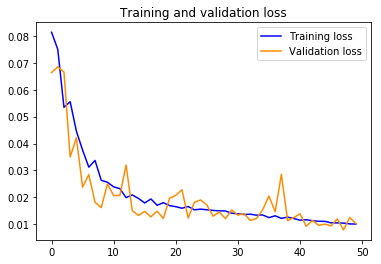

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_10_1.history['loss']
val_loss = autoencoder_train_10_1.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

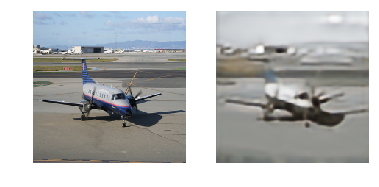

In [0]:
# encode and decode the validation images
encodedDecoded_images_10_1 = autoencoder_10_1.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_10_1[90])
plt.axis('off')

### New Autoencoder architecture

- **Coding variables = 5408**

In [0]:
input_img = Input(shape = (208, 208, 3))


def auto_encode_11(input_img):
    #encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2), padding='same')(conv1) 
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2), padding='same')(conv2)
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    encoded = MaxPooling2D((2, 2), padding='same')(conv3)

    #decoder
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5) # 216, 216, 64
    conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    conv6 = BatchNormalization()(conv6)
    up3 = UpSampling2D((2,2))(conv6) # 216, 216, 64
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded

In [0]:
#Build the model
autoencoder_11_1 = Model(input_img, auto_encode_11(input_img)) 

autoencoder_11_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_928 (Conv2D)          (None, 208, 208, 16)      448       
_________________________________________________________________
batch_normalization_63 (Batc (None, 208, 208, 16)      64        
_________________________________________________________________
max_pooling2d_366 (MaxPoolin (None, 104, 104, 16)      0         
_________________________________________________________________
conv2d_929 (Conv2D)          (None, 104, 104, 8)       1160      
_________________________________________________________________
batch_normalization_64 (Batc (None, 104, 104, 8)       32        
_________________________________________________________________
max_pooling2d_367 (MaxPoolin (None, 52, 52, 8)         0         
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_11_1.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_11_1 = autoencoder_11_1.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 14s 10ms/step - loss: 0.0406 - acc: 0.4208 - val_loss: 0.0622 - val_acc: 0.4591
Epoch 2/50
1489/1489 [==============================] - 8s 6ms/step - loss: 0.0211 - acc: 0.4962 - val_loss: 0.0471 - val_acc: 0.5470
Epoch 3/50
1489/1489 [==============================] - 8s 6ms/step - loss: 0.0172 - acc: 0.5560 - val_loss: 0.0406 - val_acc: 0.5378
Epoch 4/50
1489/1489 [==============================] - 8s 6ms/step - loss: 0.0153 - acc: 0.5844 - val_loss: 0.0281 - val_acc: 0.5661
Epoch 5/50
1489/1489 [==============================] - 8s 6ms/step - loss: 0.0139 - acc: 0.6026 - val_loss: 0.0325 - val_acc: 0.5460
Epoch 6/50
1489/1489 [==============================] - 8s 6ms/step - loss: 0.0132 - acc: 0.6150 - val_loss: 0.0195 - val_acc: 0.5409
Epoch 7/50
1489/1489 [==============================] - 8s 5ms/step - loss: 0.0126 - acc: 0.6207 - val_loss: 0.0219 - val_acc: 0.5321
Epoch 8/50
1

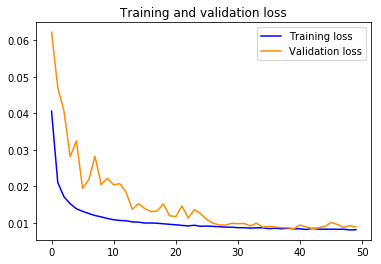

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_11_1.history['loss']
val_loss = autoencoder_train_11_1.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

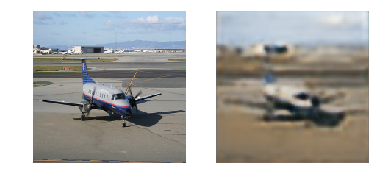

In [0]:
encodedDecoded_images_11_1 = autoencoder_11_1.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_11_1[90])
plt.axis('off')

### Another Autoencoder case

- **Coding Variables: 173056**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_12(input_img):

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv1) 
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    up1 = UpSampling2D((2,2))(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    up2 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded

In [0]:
#Build the model
autoencoder_12 = Model(input_img, auto_encode_12(input_img)) 

autoencoder_12.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_1050 (Conv2D)         (None, 208, 208, 32)      896       
_________________________________________________________________
conv2d_1051 (Conv2D)         (None, 104, 104, 32)      9248      
_________________________________________________________________
conv2d_1052 (Conv2D)         (None, 104, 104, 64)      18496     
_________________________________________________________________
conv2d_1053 (Conv2D)         (None, 52, 52, 64)        36928     
_________________________________________________________________
conv2d_1054 (Conv2D)         (None, 52, 52, 128)       73856     
_________________________________________________________________
conv2d_1055 (Conv2D)         (None, 26, 26, 128)       147584    
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_12.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_12 = autoencoder_12.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 35s 23ms/step - loss: 0.0865 - acc: 0.4440 - val_loss: 0.0717 - val_acc: 0.4968
Epoch 2/50
1489/1489 [==============================] - 22s 15ms/step - loss: 0.0808 - acc: 0.4937 - val_loss: 0.0697 - val_acc: 0.4727
Epoch 3/50
1489/1489 [==============================] - 22s 15ms/step - loss: 0.0677 - acc: 0.4710 - val_loss: 0.0582 - val_acc: 0.4965
Epoch 4/50
1489/1489 [==============================] - 22s 15ms/step - loss: 0.0614 - acc: 0.4426 - val_loss: 0.0529 - val_acc: 0.3927
Epoch 5/50
1489/1489 [==============================] - 22s 15ms/step - loss: 0.0572 - acc: 0.4460 - val_loss: 0.0657 - val_acc: 0.4725
Epoch 6/50
1489/1489 [==============================] - 22s 15ms/step - loss: 0.0485 - acc: 0.4259 - val_loss: 0.0477 - val_acc: 0.4855
Epoch 7/50
1489/1489 [==============================] - 22s 15ms/step - loss: 0.0459 - acc: 0.4454 - val_loss: 0.0327 - val_acc: 0.3858


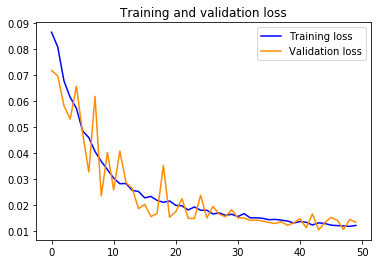

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_12.history['loss']
val_loss = autoencoder_train_12.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

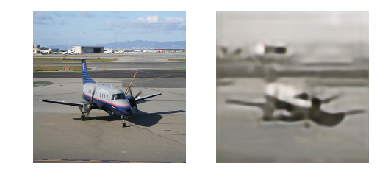

In [0]:
encodedDecoded_images_12 = autoencoder_12.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_12[90])
plt.axis('off')

### Another Autoencoder option

- **Coding Variable: 173056**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_14(input_img):

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = Conv2D(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up1 = UpSampling2D((2,2))(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    up2 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    up3 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded

In [0]:
#Build the model
autoencoder_14 = Model(input_img, auto_encode_14(input_img)) 

autoencoder_14.summary()

W0828 21:04:50.971092 140073170360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 21:04:50.972461 140073170360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0828 21:04:54.684847 140073170360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0828 21:04:55.306577 140073170360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neigh

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 104, 104, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 104, 104, 32)      128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 104, 104, 64)      18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        36928     
__________

- **Epochs=40, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_14.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_14 = autoencoder_14.fit(x_train, x_train, epochs=40, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

W0828 21:05:13.351368 140073170360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Train on 1489 samples, validate on 1470 samples
Epoch 1/40
1489/1489 [==============================] - 37s 25ms/step - loss: 0.0357 - acc: 0.4076 - val_loss: 0.0321 - val_acc: 0.4465
Epoch 2/40
1489/1489 [==============================] - 26s 17ms/step - loss: 0.0214 - acc: 0.4232 - val_loss: 0.0427 - val_acc: 0.4651
Epoch 3/40
1489/1489 [==============================] - 26s 17ms/step - loss: 0.0203 - acc: 0.4199 - val_loss: 0.0562 - val_acc: 0.4699
Epoch 4/40
1489/1489 [==============================] - 26s 17ms/step - loss: 0.0180 - acc: 0.4343 - val_loss: 0.0557 - val_acc: 0.4448
Epoch 5/40
1489/1489 [==============================] - 26s 17ms/step - loss: 0.0166 - acc: 0.4447 - val_loss: 0.0466 - val_acc: 0.4620
Epoch 6/40
1489/1489 [==============================] - 26s 17ms/step - loss: 0.0166 - acc: 0.4606 - val_loss: 0.0878 - val_acc: 0.4609
Epoch 7/40
1489/1489 [==============================] - 26s 17ms/step - loss: 0.0154 - acc: 0.4581 - val_loss: 0.0283 - val_acc: 0.4089


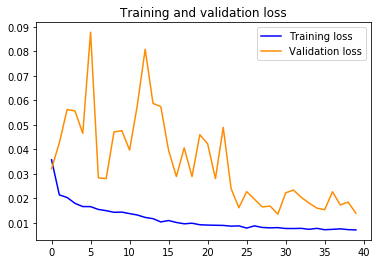

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_14.history['loss']
val_loss = autoencoder_train_14.history['val_loss']
epochs = range(40)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

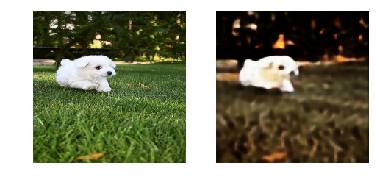

In [0]:
encodedDecoded_images_14 = autoencoder_14.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[1110])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_14[1110])
plt.axis('off')

### Another Autoencoder option

- **Coding Variables: 173056**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_15(input_img):
  
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4) 
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
   
    #decoder
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5) 
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6) 
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up1 = UpSampling2D((2,2))(conv7) 
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    up2 = UpSampling2D((2,2))(conv8)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2) 
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    up3 = UpSampling2D((2,2))(conv9)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)
    return decoded
  

In [0]:
#Build the model
autoencoder_15 = Model(input_img, auto_encode_15(input_img)) 

autoencoder_15.summary()

W0828 21:35:09.409242 140073170360192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 208, 208, 16)      448       
_________________________________________________________________
batch_normalization_5 (Batch (None, 208, 208, 16)      64        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 208, 208, 16)      2320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 208, 208, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 104, 104, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 104, 104, 32)      4640      
__________

- **Epochs=40, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_15.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_15 = autoencoder_15.fit(x_train, x_train, epochs=40, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/40
1489/1489 [==============================] - 31s 21ms/step - loss: 0.0530 - acc: 0.3801 - val_loss: 0.0488 - val_acc: 0.3820
Epoch 2/40
1489/1489 [==============================] - 23s 15ms/step - loss: 0.0276 - acc: 0.4561 - val_loss: 0.0511 - val_acc: 0.4013
Epoch 3/40
1489/1489 [==============================] - 23s 15ms/step - loss: 0.0243 - acc: 0.4416 - val_loss: 0.0704 - val_acc: 0.3717
Epoch 4/40
1489/1489 [==============================] - 23s 15ms/step - loss: 0.0209 - acc: 0.4729 - val_loss: 0.0798 - val_acc: 0.3454
Epoch 5/40
1489/1489 [==============================] - 23s 15ms/step - loss: 0.0187 - acc: 0.4889 - val_loss: 0.0691 - val_acc: 0.4198
Epoch 6/40
1489/1489 [==============================] - 23s 15ms/step - loss: 0.0173 - acc: 0.5080 - val_loss: 0.0490 - val_acc: 0.4274
Epoch 7/40
1489/1489 [==============================] - 23s 15ms/step - loss: 0.0163 - acc: 0.5151 - val_loss: 0.0589 - val_acc: 0.5181


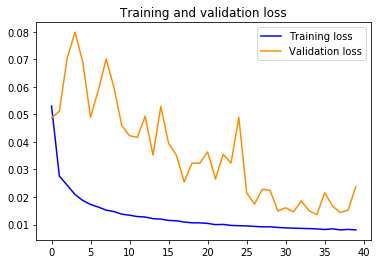

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_15.history['loss']
val_loss = autoencoder_train_15.history['val_loss']
epochs = range(40)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

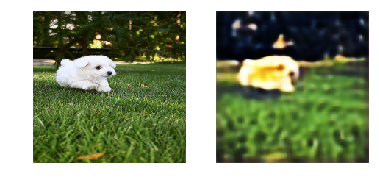

In [0]:
encodedDecoded_images_15 = autoencoder_15.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[1110])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_15[1110])
plt.axis('off')

### Another Autoencoder

- **Coding Variables: 692224**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_16(input_img):

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) 
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [0]:
#Build the model
autoencoder_16 = Model(input_img, auto_encode_16(input_img)) 

autoencoder_16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 208, 208, 32)      896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 208, 208, 32)      9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 208, 208, 32)      9248      
_________________________________________________________________
batch_normalization_25 (Batc (None, 208, 208, 32)      128       
__________

- **Epochs=40, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_16.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_16 = autoencoder_16.fit(x_train, x_train, epochs=40, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/40
1489/1489 [==============================] - 65s 43ms/step - loss: 0.0502 - acc: 0.3927 - val_loss: 0.0313 - val_acc: 0.3972
Epoch 2/40
1489/1489 [==============================] - 49s 33ms/step - loss: 0.0260 - acc: 0.4411 - val_loss: 0.0851 - val_acc: 0.4843
Epoch 3/40
1489/1489 [==============================] - 49s 33ms/step - loss: 0.0178 - acc: 0.4930 - val_loss: 0.1060 - val_acc: 0.3764
Epoch 4/40
1489/1489 [==============================] - 49s 33ms/step - loss: 0.0165 - acc: 0.4978 - val_loss: 0.0760 - val_acc: 0.4427
Epoch 5/40
1489/1489 [==============================] - 49s 33ms/step - loss: 0.0154 - acc: 0.4904 - val_loss: 0.1906 - val_acc: 0.3976
Epoch 6/40
1489/1489 [==============================] - 49s 33ms/step - loss: 0.0137 - acc: 0.5019 - val_loss: 0.0644 - val_acc: 0.4384
Epoch 7/40
1489/1489 [==============================] - 49s 33ms/step - loss: 0.0125 - acc: 0.5366 - val_loss: 0.0579 - val_acc: 0.4489


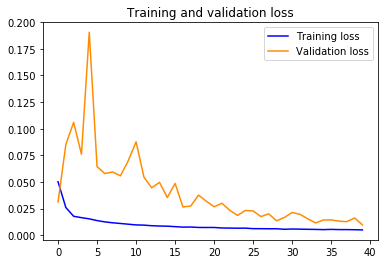

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_16.history['loss']
val_loss = autoencoder_train_16.history['val_loss']
epochs = range(40)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

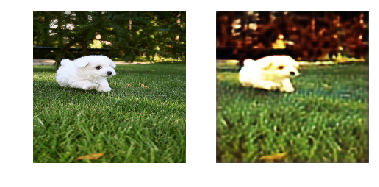

In [0]:
encodedDecoded_images_16 = autoencoder_16.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[1110])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_16[1110])
plt.axis('off')

### Another Autoencoder option

- **Coding variables: 173056**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_17(input_img):

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up1 = UpSampling2D((2,2))(conv5) #14 x 14 x 64
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up3 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3) # 28 x 28 x 1
    return decoded

In [0]:
#Build the model
autoencoder_17 = Model(input_img, auto_encode_17(input_img)) 

autoencoder_17.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 208, 208, 32)      896       
_________________________________________________________________
batch_normalization_39 (Batc (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 208, 208, 32)      9248      
_________________________________________________________________
batch_normalization_40 (Batc (None, 208, 208, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 104, 104, 32)      0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 104, 104, 64)      18496     
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_17.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_17 = autoencoder_17.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 37s 25ms/step - loss: 0.0473 - acc: 0.4224 - val_loss: 0.0508 - val_acc: 0.3938
Epoch 2/50
1489/1489 [==============================] - 33s 22ms/step - loss: 0.0232 - acc: 0.4841 - val_loss: 0.0813 - val_acc: 0.3855
Epoch 3/50
1489/1489 [==============================] - 33s 22ms/step - loss: 0.0194 - acc: 0.4999 - val_loss: 0.0572 - val_acc: 0.3956
Epoch 4/50
1489/1489 [==============================] - 33s 22ms/step - loss: 0.0175 - acc: 0.5253 - val_loss: 0.0742 - val_acc: 0.4768
Epoch 5/50
1489/1489 [==============================] - 33s 22ms/step - loss: 0.0161 - acc: 0.5128 - val_loss: 0.0907 - val_acc: 0.4291
Epoch 6/50
1489/1489 [==============================] - 33s 22ms/step - loss: 0.0142 - acc: 0.5450 - val_loss: 0.0870 - val_acc: 0.4696
Epoch 7/50
1489/1489 [==============================] - 33s 22ms/step - loss: 0.0131 - acc: 0.5685 - val_loss: 0.0748 - val_acc: 0.4892


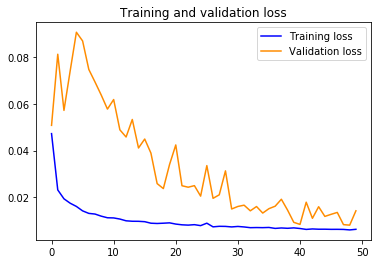

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_17.history['loss']
val_loss = autoencoder_train_17.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

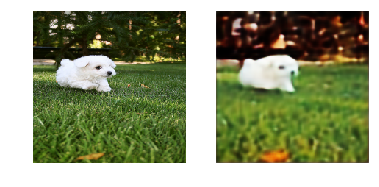

In [0]:
encodedDecoded_images_17 = autoencoder_17.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[1110])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_17[1110])
plt.axis('off')

### New Autoencoder architecture

- **Coding Variables: 692224**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_18(input_img):

    conv1 = Conv2D(32, (3, 3), padding='same')(input_img)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv4 = LeakyReLU(alpha=0.01)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = LeakyReLU(alpha=0.01)(conv4)
    conv4 = BatchNormalization()(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv5=LeakyReLU(alpha=0.01)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), padding='same')(conv5)
    conv5=LeakyReLU(alpha=0.01)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv6=LeakyReLU(alpha=0.01)(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv6)
    con6=LeakyReLU(alpha=0.01)(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), padding='same')(up1)
    conv7=LeakyReLU(alpha=0.01)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), padding='same')(conv7)
    conv7=LeakyReLU(alpha=0.01)(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

W0829 07:35:42.735753 140046066116480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 07:35:42.778684 140046066116480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



In [0]:
#Build the model
autoencoder_18 = Model(input_img, auto_encode_18(input_img)) 

autoencoder_18.summary()

W0829 07:35:47.149523 140046066116480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 07:35:47.193478 140046066116480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 07:35:47.194702 140046066116480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0829 07:35:50.483527 140046066116480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0829 07:35:50.671911 1400

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 208, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128       
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_18.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_18 = autoencoder_18.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

W0829 07:35:57.346909 140046066116480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 61s 41ms/step - loss: 0.0441 - acc: 0.4549 - val_loss: 0.0408 - val_acc: 0.4319
Epoch 2/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0195 - acc: 0.5047 - val_loss: 0.1665 - val_acc: 0.3258
Epoch 3/50
1489/1489 [==============================] - 44s 29ms/step - loss: 0.0184 - acc: 0.4828 - val_loss: 0.0615 - val_acc: 0.5177
Epoch 4/50
1489/1489 [==============================] - 44s 30ms/step - loss: 0.0148 - acc: 0.5229 - val_loss: 0.1171 - val_acc: 0.4759
Epoch 5/50
1489/1489 [==============================] - 44s 30ms/step - loss: 0.0139 - acc: 0.5344 - val_loss: 0.0781 - val_acc: 0.5111
Epoch 6/50
1489/1489 [==============================] - 44s 30ms/step - loss: 0.0126 - acc: 0.5402 - val_loss: 0.0944 - val_acc: 0.5868
Epoch 7/50
1489/1489 [==============================] - 44s 30ms/step - loss: 0.0116 - acc: 0.5701 - val_loss: 0.0632 - val_acc: 0.5887


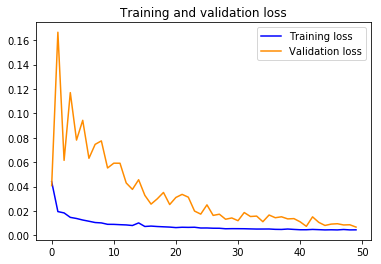

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_18.history['loss']
val_loss = autoencoder_train_18.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

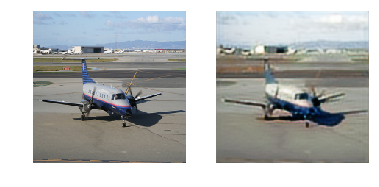

In [0]:
encodedDecoded_images_18 = autoencoder_18.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_18[90])
plt.axis('off')

(-0.5, 207.5, 207.5, -0.5)

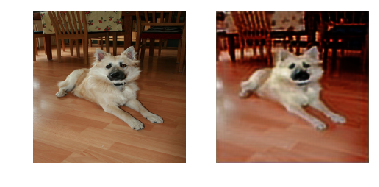

In [0]:
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[700])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_18[700])
plt.axis('off')

### Another Autoencoder

- **Coding Variables: 692224**
- **LeakyReLU(alpha=0.2), BatchNormalization,  MaxPooling2D**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_22(input_img):

    conv1 = Conv2D(32, (3, 3), padding='same')(input_img)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)
    conv4 = BatchNormalization()(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv5=LeakyReLU(alpha=0.2)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), padding='same')(conv5)
    conv5=LeakyReLU(alpha=0.2)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv6=LeakyReLU(alpha=0.2)(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv6)
    conv6=LeakyReLU(alpha=0.2)(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(32, (3, 3), padding='same')(up1)
    conv7=LeakyReLU(alpha=0.2)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), padding='same')(conv7)
    conv7=LeakyReLU(alpha=0.2)(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

In [0]:
#Build the model
autoencoder_22 = Model(input_img, auto_encode_22(input_img)) 

autoencoder_22.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 208, 208, 32)      896       
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 208, 208, 32)      9248      
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 208, 208, 32)      128       
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_22.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_22 = autoencoder_22.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 47s 32ms/step - loss: 0.0494 - acc: 0.4799 - val_loss: 0.0328 - val_acc: 0.4933
Epoch 2/50
1489/1489 [==============================] - 44s 29ms/step - loss: 0.0196 - acc: 0.4974 - val_loss: 0.0422 - val_acc: 0.4478
Epoch 3/50
1489/1489 [==============================] - 44s 30ms/step - loss: 0.0243 - acc: 0.4763 - val_loss: 0.0883 - val_acc: 0.4517
Epoch 4/50
1489/1489 [==============================] - 44s 30ms/step - loss: 0.0152 - acc: 0.5379 - val_loss: 0.1087 - val_acc: 0.4185
Epoch 5/50
1489/1489 [==============================] - 44s 29ms/step - loss: 0.0160 - acc: 0.5309 - val_loss: 0.1131 - val_acc: 0.5074
Epoch 6/50
1489/1489 [==============================] - 44s 30ms/step - loss: 0.0131 - acc: 0.5636 - val_loss: 0.1657 - val_acc: 0.3126
Epoch 7/50
1489/1489 [==============================] - 44s 29ms/step - loss: 0.0138 - acc: 0.5349 - val_loss: 0.0786 - val_acc: 0.4506


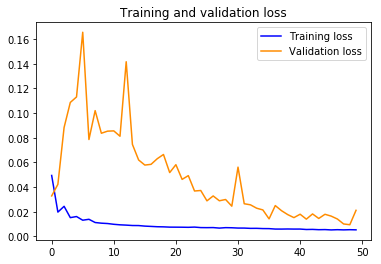

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_22.history['loss']
val_loss = autoencoder_train_22.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

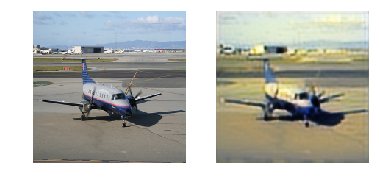

In [0]:
encodedDecoded_images_22 = autoencoder_22.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_22[90])
plt.axis('off')

### Autoencoder Architecture

- **Coding Variables: 692224**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_20(input_img):

    conv1 = Conv2D(32, (3, 3), padding='same')(input_img)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv2 = Conv2D(32, (3, 3), padding='same')(conv1)
    conv2 = LeakyReLU(alpha=0.01)(conv2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(64, (3, 3), padding='same')(pool1)
    conv3 = LeakyReLU(alpha=0.01)(conv3)
    conv4 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv4 = LeakyReLU(alpha=0.01)(conv4)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4) 
    conv5 = Conv2D(128, (3, 3), padding='same')(pool2)
    conv5 = LeakyReLU(alpha=0.01)(conv5)
    conv6 = Conv2D(128, (3, 3), padding='same')(conv5)
    conv6 = LeakyReLU(alpha=0.01)(conv6)
    conv7 = Conv2D(256, (3, 3), padding='same')(conv6)
    conv7 = LeakyReLU(alpha=0.01)(conv7)
    conv8 = Conv2D(256, (3, 3), padding='same')(conv7)
    conv8 = LeakyReLU(alpha=0.01)(conv8)
   
    #decoder
    conv9 = Conv2D(128, (3, 3), padding='same')(conv8)
    conv9 = LeakyReLU(alpha=0.01)(conv9)
    conv10 = Conv2D(128, (3, 3), padding='same')(conv9)
    conv10 = LeakyReLU(alpha=0.01)(conv10)
    conv11 = Conv2D(64, (3, 3), padding='same')(conv10)
    conv11 = LeakyReLU(alpha=0.01)(conv11)
    conv12 = Conv2D(64, (3, 3), padding='same')(conv11)
    conv12 = LeakyReLU(alpha=0.01)(conv12)
    up1 = UpSampling2D((2,2))(conv12)
    conv13 = Conv2D(32, (3, 3), padding='same')(up1)
    conv13 = LeakyReLU(alpha=0.01)(conv13)
    conv14 = Conv2D(32, (3, 3), padding='same')(conv13)
    conv14 = LeakyReLU(alpha=0.01)(conv14)
    up2 = UpSampling2D((2,2))(conv14) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [0]:
#Build the model
autoencoder_20 = Model(input_img, auto_encode_20(input_img)) 

autoencoder_20.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 208, 208, 32)      896       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 208, 208, 32)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 208, 208, 32)      9248      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 208, 208, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 104, 104, 32)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 104, 104, 64)      18496     
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_20.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_20 = autoencoder_20.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 37s 25ms/step - loss: 0.0837 - acc: 0.4563 - val_loss: 0.0711 - val_acc: 0.2049
Epoch 2/50
1489/1489 [==============================] - 36s 24ms/step - loss: 0.0819 - acc: 0.3440 - val_loss: 0.0697 - val_acc: 0.4890
Epoch 3/50
1489/1489 [==============================] - 36s 24ms/step - loss: 0.0761 - acc: 0.4278 - val_loss: 0.1709 - val_acc: 0.4929
Epoch 4/50
1489/1489 [==============================] - 36s 24ms/step - loss: 0.0834 - acc: 0.4286 - val_loss: 0.0474 - val_acc: 0.4174
Epoch 5/50
1489/1489 [==============================] - 36s 24ms/step - loss: 0.0588 - acc: 0.3552 - val_loss: 0.0424 - val_acc: 0.3122
Epoch 6/50
1489/1489 [==============================] - 36s 24ms/step - loss: 0.0522 - acc: 0.3842 - val_loss: 0.1485 - val_acc: 0.3443
Epoch 7/50
1489/1489 [==============================] - 36s 24ms/step - loss: 0.0490 - acc: 0.3733 - val_loss: 0.0428 - val_acc: 0.4712


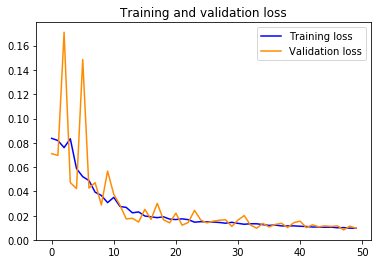

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_20.history['loss']
val_loss = autoencoder_train_20.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

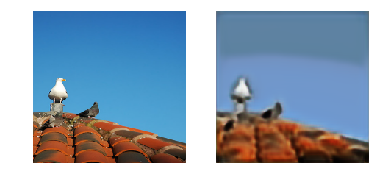

In [0]:
encodedDecoded_images_20 = autoencoder_20.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[1230])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_20[1230])
plt.axis('off')

### Autoencoder Architecture

- **Coding Variables: 692224**

In [0]:
input_img = Input(shape = (208, 208, 3))

def auto_encode_21(input_img):

    conv1 = Conv2D(32, (3, 3), padding='same')(input_img)
    conv1 = LeakyReLU(alpha=0.3)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), strides=(2,2), padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.3)(conv1)
    conv1 = BatchNormalization()(conv1)
    #pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv2 = LeakyReLU(alpha=0.3)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), strides=(2,2), padding='same')(conv2)
    conv2 = LeakyReLU(alpha=0.3)(conv2)
    conv2 = BatchNormalization()(conv2)
    #pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), padding='same')(conv2)
    conv3 = LeakyReLU(alpha=0.3)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU(alpha=0.3)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv3)
    conv4 = LeakyReLU(alpha=0.3)(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = LeakyReLU(alpha=0.3)(conv4)
    conv4 = BatchNormalization()(conv4)
   
    #decoder
    conv5 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv5=LeakyReLU(alpha=0.3)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), padding='same')(conv5)
    conv5=LeakyReLU(alpha=0.3)(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv6=LeakyReLU(alpha=0.3)(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), padding='same')(conv6)
    con6=LeakyReLU(alpha=0.3)(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), padding='same')(up1)
    conv7=LeakyReLU(alpha=0.3)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), padding='same')(conv7)
    conv7=LeakyReLU(alpha=0.3)(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) 
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) 
    return decoded

In [0]:
#Build the model
autoencoder_21 = Model(input_img, auto_encode_21(input_img)) 

autoencoder_21.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 208, 208, 3)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 208, 208, 32)      896       
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 208, 208, 32)      0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 208, 208, 32)      128       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 104, 104, 32)      9248      
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 104, 104, 32)      0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 104, 104, 32)      128       
__________

- **Epochs=50, batch_size=64, loss=mse, optimizer=RMSprop()**

In [0]:
#Compile the model and train
autoencoder_21.compile(loss='mean_squared_error', optimizer = RMSprop(), metrics=['accuracy']) #here we create the model
autoencoder_train_21 = autoencoder_21.fit(x_train, x_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val, x_val))
#autoencoder_21.save("autoencoder_21.h5")

Train on 1489 samples, validate on 1470 samples
Epoch 1/50
1489/1489 [==============================] - 43s 29ms/step - loss: 0.0519 - acc: 0.4503 - val_loss: 0.0427 - val_acc: 0.4284
Epoch 2/50
1489/1489 [==============================] - 40s 27ms/step - loss: 0.0224 - acc: 0.4884 - val_loss: 0.1411 - val_acc: 0.3885
Epoch 3/50
1489/1489 [==============================] - 40s 27ms/step - loss: 0.0194 - acc: 0.4336 - val_loss: 0.0722 - val_acc: 0.3391
Epoch 4/50
1489/1489 [==============================] - 40s 27ms/step - loss: 0.0182 - acc: 0.4686 - val_loss: 0.0975 - val_acc: 0.4297
Epoch 5/50
1489/1489 [==============================] - 40s 27ms/step - loss: 0.0166 - acc: 0.4799 - val_loss: 0.0980 - val_acc: 0.3211
Epoch 6/50
1489/1489 [==============================] - 40s 27ms/step - loss: 0.0142 - acc: 0.5280 - val_loss: 0.1051 - val_acc: 0.4379
Epoch 7/50
1489/1489 [==============================] - 40s 27ms/step - loss: 0.0124 - acc: 0.5459 - val_loss: 0.1086 - val_acc: 0.3122


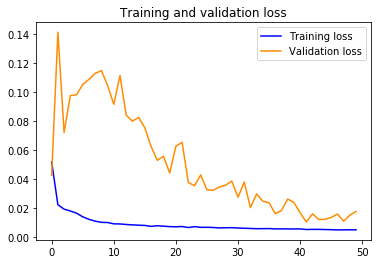

In [0]:
#plot the loss between training and validation 
loss = autoencoder_train_21.history['loss']
val_loss = autoencoder_train_21.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

(-0.5, 207.5, 207.5, -0.5)

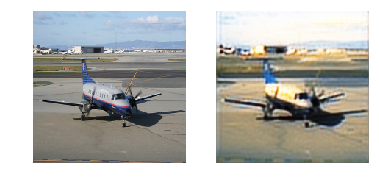

In [0]:
encodedDecoded_images_21 = autoencoder_21.predict(x_val)

# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(x_val[90])
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(encodedDecoded_images_21[90])
plt.axis('off')